In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    MultipleDates,
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates,
    MTDeforestationTime, MTMultipleDates
)
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [3]:
# dataset = ParaDeforestationTime()
addPastDeforestationInput = True

# dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	
# dataset = MTMultipleDates(dates = [2019, 2020], # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	
dataset = MTDeforestationTime()	
# [2016, 2017, 2018]
# dataset = Para()
if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 10

training = True
save_probabilities = True
loadInference = False
if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58
		# exp = 63
		# exp = 52
		# exp = 64
		# exp = 66
		exp = 66
		exp = 68
		
		# =============
		# exp = 72 # train 2015-2018
		# exp = 69 # train 2016-2018
		# exp = 70 # train 2017-2018
		
		# train 2018-2019. test 2018-2019
		# exp = 39 # old 
		exp = 76 # 88.4 mAP
		# exp = 71 # 89.5 mAP

		# =============
		
		### exp = 73
		# exp = 71
		# exp = 61

		exp = 77 # good?
		# exp = 78 # good but too short?
	if type(dataset) == MTDeforestationTime:
		exp = 28
	if type(dataset) == MTMultipleDates:
		exp = 73 # train 2018-2019
		# exp = 74 # train 2016-2019
		# exp = 75 # train 2017-2019
		
		exp = 78 # 2019-2020

else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 79

In [4]:
exp

79

In [5]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [6]:
# ic(type(dataset), exp, dataset.dates)


In [7]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif
Mask label shape:  
 (16795, 10420) 
 Unique values:  
 [0 1 2]


In [8]:
# np.save('label_not_independent.npy', label_mask)


In [9]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [10]:
label_mask.dtype

dtype('uint8')

In [11]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [12]:
label_mask.dtype

dtype('uint8')

In [13]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| np.unique(deforestation_time, return_counts=True): (array([0.        , 0.07692308, 0.15384616, 0.23076925, 0.30769232,
                                                              0.3846154 , 0.4615385 , 0.53846157, 0.61538464, 0.6923077 ,
                                                              0.7692308 , 0.84615386, 0.923077  , 1.        ], dtype=float32),
                                                        array([112663205,   2051611,   1054095,   1098902,   1007787,    876898,
                                                                 648966,    708580,    287191,    313901,    338545,    240796,
                                                                1332783,  52380640], dtype=int64))
ic| deforestation_time.shape: (16795, 10420, 1)
    image_stack.shape: (16795, 10420, 20)
ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420)


In [14]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.07692308, 0.15384616, 0.23076925, 0.30769232,
        0.3846154 , 0.4615385 , 0.53846157, 0.61538464, 0.6923077 ,
        0.7692308 , 0.84615386, 0.923077  , 1.        ], dtype=float32),
 array([112663205,   2051611,   1054095,   1098902,   1007787,    876898,
           648966,    708580,    287191,    313901,    338545,    240796,
          1332783,  52380640], dtype=int64))

(-0.5, 10419.5, 16794.5, -0.5)

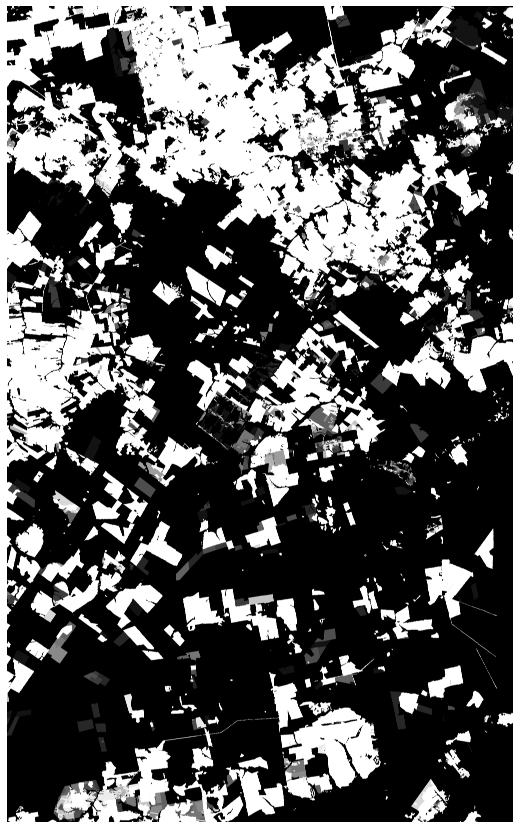

In [15]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [16]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (16795, 10420, 21)
ic| channels: 21


21

In [17]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [18]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


ic| im_idx_row.shape: (16795, 10420, 1)
    im_idx_col.shape: (16795, 10420, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (16795, 10420, 2), im_idx.dtype: dtype('uint16')


In [19]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

ic| coords.shape: (439, 271, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (118969, 2), coords.dtype: dtype('uint16')
ic| coords_train.shape: (54516, 2), coords_val.shape: (13175, 2)


In [20]:
label_mask.shape

(16795, 10420)

(-0.5, 10419.5, 16794.5, -0.5)

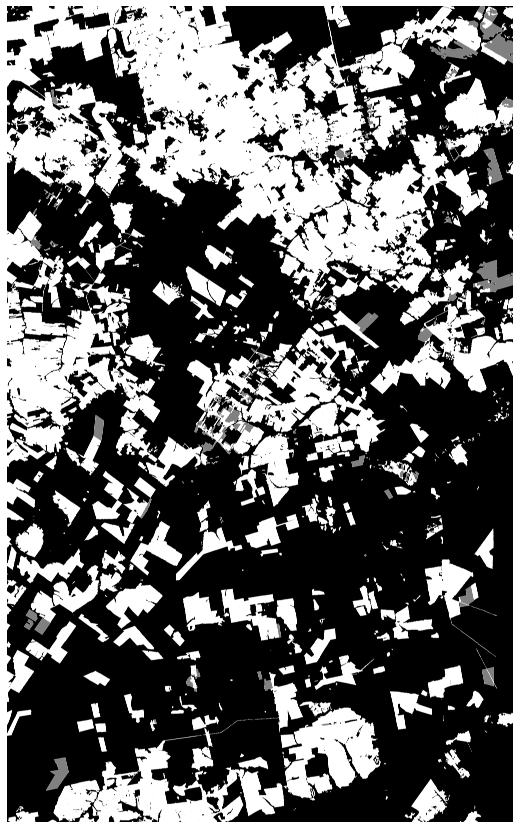

In [21]:

plt.figure(figsize=(15,15))
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [22]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [23]:
if training == True:
    print(coords_train)

[[    0  2090]
 [    0  2128]
 [    0  2166]
 ...
 [16644  8132]
 [16644  8170]
 [16644  8208]]


In [24]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


training samples:  (3406, 2) validation samples:  (610, 2)


In [25]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [26]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [27]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [28]:
inputSnipShow = False

In [29]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [30]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [31]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [32]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [33]:
inputSnipShow = True
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

[  722 10108]


IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [ ]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [ ]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [ ]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [ ]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/MT/exp79'

In [ ]:
channels

21

In [ ]:
image_stack.shape

(16795, 10420, 21)

In [ ]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model, history

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

time:  0


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (SpatialDropout2D)    (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
______________________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


319/319 [==============================] - 26s 59ms/step - loss: 0.0798 - accuracy: 0.8455 - val_loss: 0.0246 - val_accuracy: 0.9511

Epoch 00001: val_loss improved from inf to 0.02457, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp79/models\resunet_0.h5
Epoch 2/100
  1/319 [..............................] - ETA: 13s - loss: 0.0716 - accuracy: 0.8871

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


319/319 [==============================] - 18s 55ms/step - loss: 0.0609 - accuracy: 0.8925 - val_loss: 0.0266 - val_accuracy: 0.9528

Epoch 00002: val_loss did not improve from 0.02457
Epoch 3/100
319/319 [==============================] - 18s 55ms/step - loss: 0.0556 - accuracy: 0.9022 - val_loss: 0.0205 - val_accuracy: 0.9574

Epoch 00003: val_loss improved from 0.02457 to 0.02049, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp79/models\resunet_0.h5
Epoch 4/100
319/319 [==============================] - 18s 55ms/step - loss: 0.0533 - accuracy: 0.9044 - val_loss: 0.0225 - val_accuracy: 0.9591

Epoch 00004: val_loss did not improve from 0.02049
Epoch 5/100
319/319 [==============================] - 18s 55ms/step - loss: 0.0523 - accuracy: 0.9041 - val_loss: 0.0175 - val_accuracy: 0.9599

Epoch 00005: val_loss improved from 0.02049 to 0.01752, saving model to D:/Jorge/datasets/deforestation/experiments/MT/exp79/models\resunet_0.h5
Epoch 6/100
319/319 [===============

In [ ]:
image_stack.shape

(16795, 10420, 21)

In [ ]:
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [ ]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [ ]:
image_stack.shape

(16795, 10420, 21)

In [ ]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-5.0 -12.0


In [ ]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], inference_times), dtype = np.float32)

    new_model = utils_v1.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None)

    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    
            

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)

            
            # Recinstructing predicted map
            start_test = time.time()
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp79/models/resunet_0.h5'


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [ ]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [ ]:
del image1_pad


In [ ]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range (0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




0
1
2
3
4
5
6
7
8
9


In [ ]:
useLessInferenceRuns = False
if useLessInferenceRuns == True:

    reducedInferenceRuns = 3
    # prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


In [ ]:
prob_rec.shape

(16800, 10432, 10)

In [ ]:
prob_rec.shape

(16800, 10432, 10)

In [ ]:
mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [ ]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 2.6869556e-17
    np.mean(mean_prob): 0.014009241
    np.max(mean_prob): 0.99999964


(2.6869556e-17, 0.014009241, 0.99999964)

In [ ]:
ic(mean_prob.shape)

ic| mean_prob.shape: (16800, 10432)


(16800, 10432)

In [ ]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

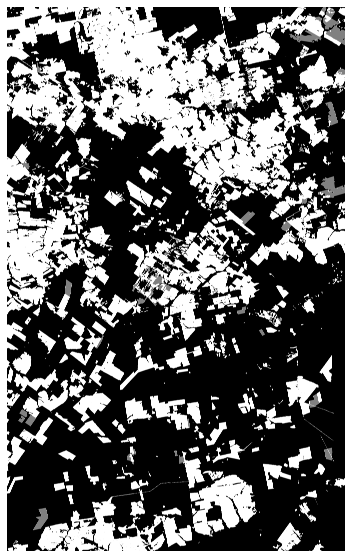

In [ ]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [ ]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [ ]:
mean_prob.shape

(16795, 10420)

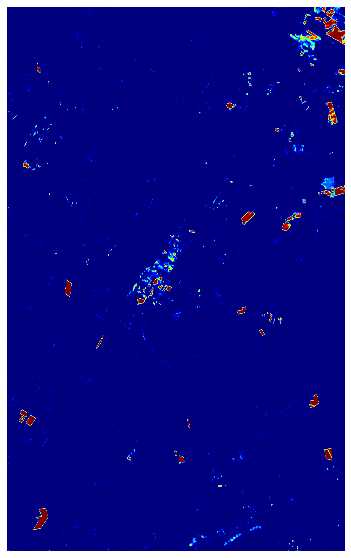

In [ ]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [ ]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(16795, 10420)


In [ ]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(44666931,)
(array([0, 1], dtype=uint8), array([43791579,   875352], dtype=int64))


In [ ]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

83.03


In [ ]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (16800, 10432, 10)


In [ ]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [ ]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [ ]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 8.35778e-28
    np.mean(prob_rec): 0.0140036475
    np.max(prob_rec): 1.0
ic| prob_rec.shape: (10, 16800, 10432, 1)


(10, 16800, 10432, 1)

In [ ]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [ ]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.0064900997
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 9.273291e-16
    np.mean(pred_entropy): 0.007018899
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (16800, 10432)
    pred_entropy_to_show.shape: (16795, 10420)


((16800, 10432), (16795, 10420))

In [ ]:
prob_rec.shape

(10, 16800, 10432, 1)

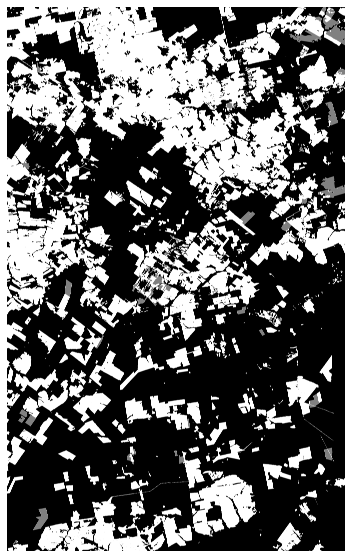

In [ ]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [ ]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 10419.5, 16794.5, -0.5)

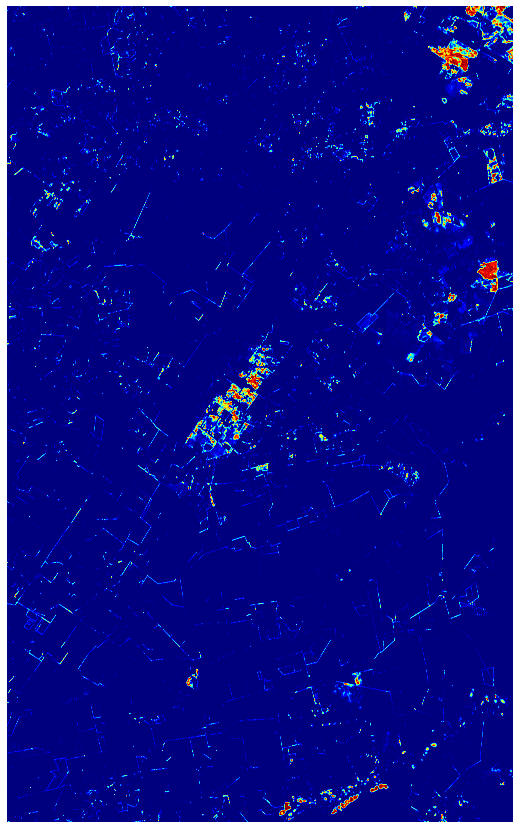

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

In [ ]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (16800, 10432)


(16800, 10432)

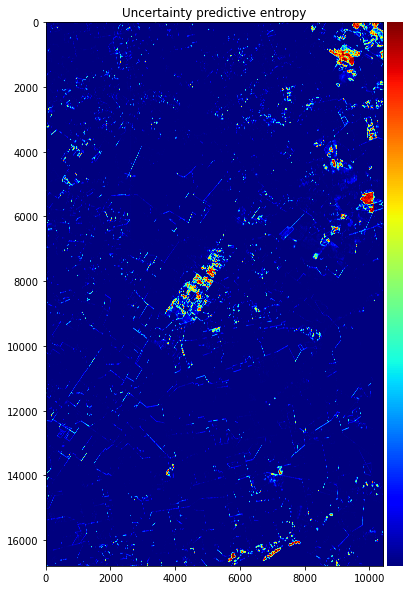

In [ ]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [ ]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 16800, 10432, 1)
ic| np.min(prob_rec): 8.35778e-28
    np.mean(prob_rec): 0.0140036475
    np.max(prob_rec): 1.0


(8.35778e-28, 0.0140036475, 1.0)

In [ ]:

pred_entropy_single = single_experiment_entropy(prob_rec[0])

'''
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


ic| pred_entropy.shape: (16800, 10432)


"\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [ ]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([70001560, 84001872, 21000468], dtype=int64))


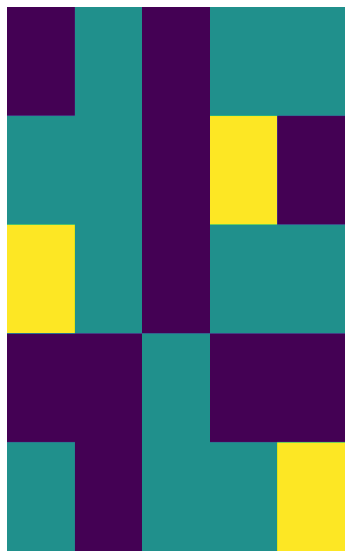

In [ ]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [ ]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [ ]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  2273209, 172730691], dtype=int64))


(array([  0, 255], dtype=uint8), array([  2273209, 172730691], dtype=int64))

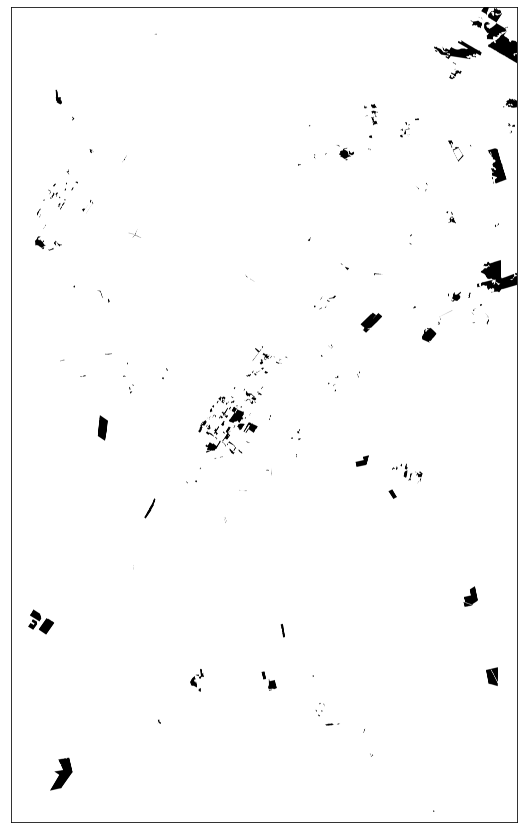

In [ ]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [ ]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (21000468,)
ic| label_mask_val_valid.shape: (11808451,)


(11808451,)

In [ ]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [ ]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.649212, F-Score=0.954


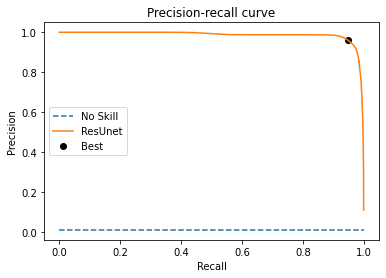

In [ ]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [ ]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5
# threshold = 0.698

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(16795, 10420)
(array([0., 1.], dtype=float32), array([172990527,   2013373], dtype=int64))


ic| predicted_unpad.shape: (16795, 10420)
    predicted.shape: (16795, 10420)


In [ ]:
threshold

0.5

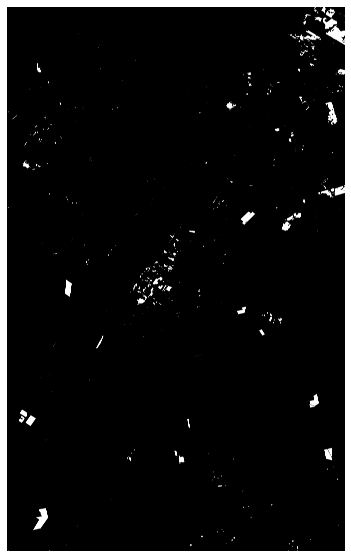

In [ ]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [ ]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [ ]:
# mean_prob_unpad.shape

In [ ]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [ ]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [ ]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [ ]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [ ]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (16795, 10420)
    label_mask_current_deforestation.shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)
    mean_prob.shape: (16795, 10420)


((16795, 10420),
 (16795, 10420),
 (16795, 10420),
 (16795, 10420),
 (16795, 10420))

In [ ]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44666931,)


(44666931,)

In [ ]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172990527,   2013373], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([173077312,   1926588], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174917115,     86785], dtype=int64))
ic| predicted.shape: (16795, 10420), label_mask.shape: (16795, 10420)
ic| predicted_masked.shape: (70001560,)
    label_masked.shape: (70001560,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([43774861,   859293, 25367406], dtype=int64))
ic| predicted_masked.shape: (44634154,)
    label_masked.shape: (44634154,)


In [ ]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [ ]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 72.63, precision: 83.88, recall: 64.04


(72.63, 83.88, 64.04)

### Metrics for validation set in forest/deforestation detection

In [ ]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (16795, 10420)


(16795, 10420)

In [ ]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [ ]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 95.1
    precision_val: 95.66
    recall_val: 94.55
    mAP_val: 98.62


(95.1, 95.66, 94.55, 98.62)

In [ ]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [ ]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([174306063,    697837], dtype=int64))


In [ ]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (16795, 10420)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   522229, 174306063,    175608], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   522229, 174306063,    175608], dtype=int64))

In [ ]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (16795, 10420)
    label_mask.shape: (16795, 10420)


((16795, 10420), (16795, 10420))

In [ ]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

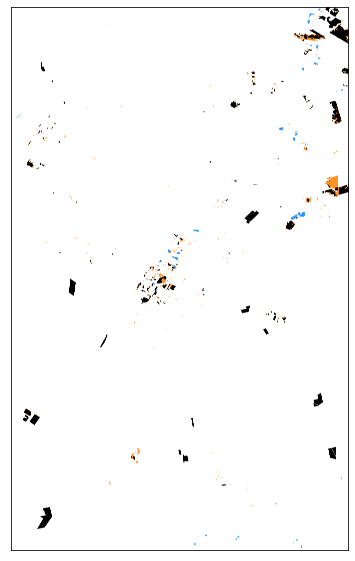

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


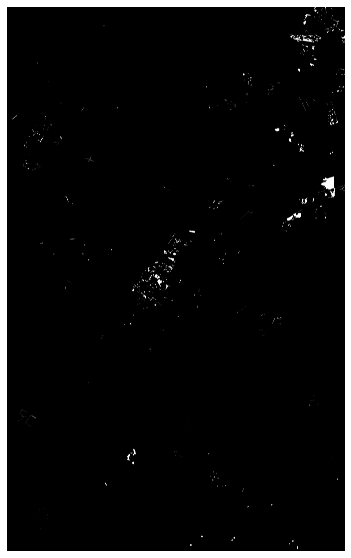

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [ ]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (16795, 10420)
ic| mask_amazon_ts.shape: (16795, 10420)
ic| label_mask_test.shape: (70001560,)
ic| error_mask_test.shape: (44634154,)


(44634154,)

In [ ]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [ ]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  

ic| pred_entropy.shape: (16800, 10432)
    utils_v1.unpadIm(pred_entropy, npad).shape: (16795, 10420)
    mask_amazon_ts.shape: (16795, 10420)
    label_mask_test.shape: (70001560,)


In [ ]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [ ]:
pred_entropy_single_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_amazon_ts),
        label_mask_test)

pred_entropy_single_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [ ]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([11500, 12500,  9000, 10000])
    dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (16795, 10420)


(16795, 10420)

ic| dataset.previewLims1: array([11500, 12500,  9000, 10000])
    dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


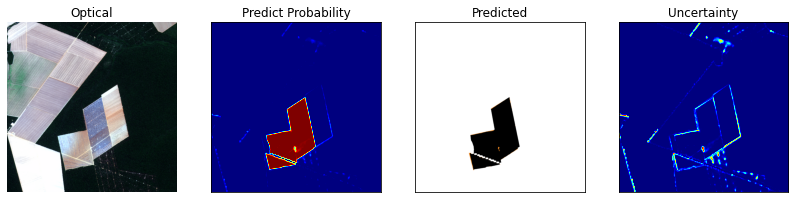

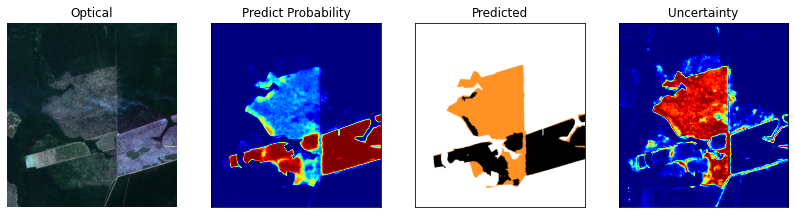

In [ ]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [ ]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.pred_entropy_single
# predictor = Predictor.MI

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [ ]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): 2.1051666e-14
    np.mean(uncertainty): 0.010467322
    np.max(uncertainty): 0.36787948
ic| np.min(pred_entropy): 9.273291e-16
    np.mean(pred_entropy): 0.007018899
    np.max(pred_entropy): 0.36787948


(9.273291e-16, 0.007018899, 0.36787948)

In [ ]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (44634154,), uncertainty.shape: (44634154,)
ic| roc_auc: 0.9847952693691884


0.9847952693691884

Best Threshold=0.005192, G-Mean=0.934


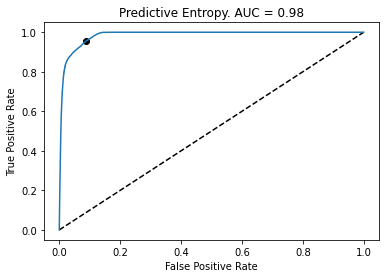

In [ ]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [ ]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.0051918803


In [ ]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [ ]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [ ]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [ ]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [ ]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [ ]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [ ]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [ ]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [ ]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [ ]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [ ]:
ic(thresholds)

ic| thresholds: array([0.00070097, 0.00070097, 0.00070098, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.00070097, 0.00070097, 0.00070098, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [ ]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.264444, F-Score=0.246


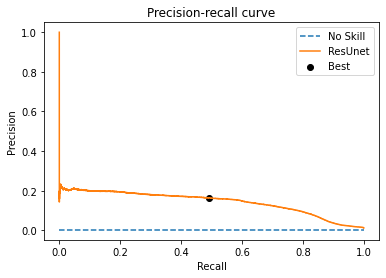

In [ ]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [ ]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [ ]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 2.1051666e-14
    np.average(uncertainty): 0.010467322
    np.max(uncertainty): 0.36787948


(2.1051666e-14, 0.010467322, 0.36787948)

In [ ]:
# plt.hist(uncertainty)

In [ ]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [ ]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (44634154,)
    label_mask_current_deforestation_test.shape: (44634154,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [ ]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 2.1051666e-14
    np.mean(uncertainty): 0.010467322
    np.max(uncertainty): 0.36787948


(2.1051666e-14, 0.010467322, 0.36787948)

In [ ]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (44634154,)


(44634154,)

In [ ]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([43451756,  1182398], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([109976377,   2233594,  62793929], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64))


((array([0, 1], dtype=uint8), array([43451756,  1182398], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([109976377,   2233594,  62793929], dtype=int64)),
 (array([0, 1], dtype=uint8), array([105002340,  70001560], dtype=int64)))

In [ ]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.02649087960757585


0.02649087960757585

In [ ]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.02649087960757585


0.02649087960757585

In [ ]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
        0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (44634154,)
    label_mask_current_deforestation_test.shape: (44634154,)


threshold 0.005
(39928291,) (39928291,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4705863,)
    predicted_test_classified_incorrect.shape: (4705863,)


cm_correct [[39645831    21020]
 [    3673   257767]]


ic| TP_H + FN_H + FP_H + TN_H: 4705863
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 4705863
    len(label_mask_current_deforestation_test): 44634154


cm_incorrect [[4023284   84726]
 [ 305301  292552]]
[0.92460194 0.98595089 0.29997568 0.10543189 0.7754282  0.48933768]
threshold 0.0075
(40468997,) (40468997,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4165157,)
    predicted_test_classified_incorrect.shape: (4165157,)


cm_correct [[40166968    23152]
 [    4300   274577]]


ic| TP_H + FN_H + FP_H + TN_H: 4165157
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 4165157
    len(label_mask_current_deforestation_test): 44634154


cm_incorrect [[3502147   82594]
 [ 304674  275742]]
[0.92223801 0.98458102 0.31953827 0.09331771 0.76950683 0.4750765 ]
threshold 0.01
(40826980,) (40826980,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3807174,)
    predicted_test_classified_incorrect.shape: (3807174,)


cm_correct [[40509930    24844]
 [    5007   287199]]


ic| TP_H + FN_H + FP_H + TN_H: 3807174
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 3807174
    len(label_mask_current_deforestation_test): 44634154


cm_incorrect [[3159185   80902]
 [ 303967  263120]]
[0.92038277 0.98286483 0.33422709 0.08529733 0.76483481 0.46398524]
threshold 0.015
(41308220,) (41308220,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3325934,)
    predicted_test_classified_incorrect.shape: (3325934,)


cm_correct [[40966676    27833]
 [    6444   307267]]


ic| TP_H + FN_H + FP_H + TN_H: 3325934
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 3325934
    len(label_mask_current_deforestation_test): 44634154


cm_incorrect [[2702439   77913]
 [ 302530  243052]]
[0.91694121 0.9794588  0.35758117 0.07451545 0.75725391 0.44549124]
threshold 0.025
(41893508,) (41893508,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2740646,)
    predicted_test_classified_incorrect.shape: (2740646,)


cm_correct [[41519075    32711]
 [    9222   332500]]


ic| TP_H + FN_H + FP_H + TN_H: 2740646
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 2740646
    len(label_mask_current_deforestation_test): 44634154


cm_incorrect [[2150040   73035]
 [ 299752  217819]]
[0.9104326  0.97301315 0.38694601 0.06140244 0.74889463 0.42084854]
threshold 0.05
(42614786,) (42614786,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2019368,)
    predicted_test_classified_incorrect.shape: (2019368,)


cm_correct [[42186902    41369]
 [   14995   371520]]


ic| TP_H + FN_H + FP_H + TN_H: 2019368
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 2019368
    len(label_mask_current_deforestation_test): 44634154


cm_incorrect [[1482213   64377]
 [ 293979  178799]]
[0.899806   0.96120461 0.43235544 0.04524266 0.73526582 0.37818807]
threshold 0.08
(42997483,) (42997483,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1636671,)
    predicted_test_classified_incorrect.shape: (1636671,)
ic

cm_correct [[42528811    47839]
 [   20092   400741]]
cm_incorrect [[1140304   57907]
 [ 288882  149578]]


| TP_H + FN_H + FP_H + TN_H: 1636671
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 1636671
    len(label_mask_current_deforestation_test): 44634154


[0.89335459 0.9522566  0.4663613  0.03666858 0.72090995 0.341144  ]
threshold 0.1
(43160533,) (43160533,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1473621,)
    predicted_test_classified_incorrect.shape: (1473621,)
ic

cm_correct [[42671273    50910]
 [   23135   415215]]
cm_incorrect [[997842  54836]
 [285839 135104]]


| TP_H + FN_H + FP_H + TN_H: 1473621
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 1473621
    len(label_mask_current_deforestation_test): 44634154


[0.89078037 0.94722254 0.48320538 0.03301555 0.7112983  0.32095557]
threshold 0.15
(43451756,) (43451756,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1182398,)
    predicted_test_classified_incorrect.shape: (1182398,)
ic| TP_H + FN_H + FP_H + TN_H: 1182398
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 1182398
    len(label_mask_current_deforestation_test): 44634154


cm_correct [[42916871    58251]
 [   32127   444507]]
cm_incorrect [[752244  47495]
 [276847 105812]]
[0.8841371  0.93259608 0.51729387 0.02649088 0.69019679 0.27651774]
threshold 0.2
(43674323,) (43674323,)


ic| label_current_deforestation_test_classified_incorrect.shape: (959831,)
    predicted_test_classified_incorrect.shape: (959831,)
ic| TP_H + FN_H + FP_H + TN_H: 959831
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 959831
    len(label_mask_current_deforestation_test): 44634154


cm_correct [[43094128    65824]
 [   44334   470037]]
cm_incorrect [[574987  39922]
 [264640  80282]]
[0.87716217 0.91380929 0.54700434 0.02150441 0.66788127 0.23275407]
threshold 0.225
(43774727,) (43774727,)


ic| label_current_deforestation_test_classified_incorrect.shape: (859427,)
    predicted_test_classified_incorrect.shape: (859427,)
ic| TP_H + FN_H + FP_H + TN_H: 859427
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 859427
    len(label_mask_current_deforestation_test): 44634154


cm_correct [[43170157    70245]
 [   52048   482277]]
cm_incorrect [[498958  35501]
 [256926  68042]]
[0.87286479 0.90259112 0.56124861 0.01925492 0.65713761 0.20938062]
threshold 0.25
(43870625,) (43870625,)


ic| label_current_deforestation_test_classified_incorrect.shape: (763529,)
    predicted_test_classified_incorrect.shape: (763529,)
ic| TP_H + FN_H + FP_H + TN_H: 763529
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 763529
    len(label_mask_current_deforestation_test): 44634154


cm_correct [[43240790    75238]
 [   61049   493548]]
cm_incorrect [[428325  30508]
 [247925  56771]]
[0.86772178 0.88992187 0.5743652  0.01710638 0.65045429 0.18632014]
threshold 0.27
(43947159,) (43947159,)


ic| label_current_deforestation_test_classified_incorrect.shape: (686995,)
    predicted_test_classified_incorrect.shape: (686995,)
ic| TP_H + FN_H + FP_H + TN_H: 686995
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 686995
    len(label_mask_current_deforestation_test): 44634154


cm_correct [[43294395    79457]
 [   70231   503076]]
cm_incorrect [[374720  26289]
 [238743  47243]]
[0.86360086 0.87749844 0.58545339 0.01539169 0.64248218 0.1651934 ]
threshold 0.3
(44069507,) (44069507,)


ic| label_current_deforestation_test_classified_incorrect.shape: (564647,)
    predicted_test_classified_incorrect.shape: (564647,)
ic| TP_H + FN_H + FP_H + TN_H: 564647
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 564647
    len(label_mask_current_deforestation_test): 44634154


cm_correct [[43373421    87428]
 [   89367   519291]]
cm_incorrect [[295694  18318]
 [219607  31028]]
[0.85590034 0.8531737  0.60432355 0.01265056 0.6287845  0.12379755]
threshold 0.34
(44291085,) (44291085,)


ic| label_current_deforestation_test_classified_incorrect.shape: (343069,)
    predicted_test_classified_incorrect.shape: (343069,)
ic| TP_H + FN_H + FP_H + TN_H: 343069
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 343069
    len(label_mask_current_deforestation_test): 44634154


cm_correct [[43485382   102606]
 [  158048   545049]]
cm_incorrect [[183733   3140]
 [150926   5270]]
[0.84157306 0.77521167 0.63429936 0.00768624 0.62663496 0.03373966]
threshold 0.36
(44463761,) (44463761,)


ic| label_current_deforestation_test_classified_incorrect.shape: (170393,)
    predicted_test_classified_incorrect.shape: (170393,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 170393
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 170393
    len(label_mask_current_deforestation_test): 44634154


cm_correct [[43572598   105746]
 [  235098   550319]]
cm_incorrect [[96517     0]
 [73876     0]]
[0.8388178  0.70067111 0.64043231 0.00381755        nan 0.        ]
threshold 0.3648794801235199
(44530381,) (44530381,)


ic| label_current_deforestation_test_classified_incorrect.shape: (103773,)
    predicted_test_classified_incorrect.shape: (103773,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 103773
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 103773
    len(label_mask_current_deforestation_test): 44634154


cm_correct [[43610248   105746]
 [  264068   550319]]
cm_incorrect [[58867     0]
 [44906     0]]
[0.8388178  0.6757463  0.64043231 0.00232497        nan 0.        ]
threshold 0.3663794801235199
(44561612,) (44561612,)


ic| label_current_deforestation_test_classified_incorrect.shape: (72542,)
    predicted_test_classified_incorrect.shape: (72542,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 72542
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 72542
    len(label_mask_current_deforestation_test): 44634154


cm_correct [[43627979   105746]
 [  277568   550319]]
cm_incorrect [[41136     0]
 [31406     0]]
[0.8388178  0.66472719 0.64043231 0.00162526        nan 0.        ]


In [ ]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (44634154,)
    label_mask_current_deforestation_test.shape: (44634154,)


threshold 0.005
(44634154,) (44634154,)
cm_audited [[43753841    21020]
 [    3673   855620]]
[0.97602208 0.99572556]
threshold 0.0075
(44634154,) (44634154,)
cm_audited [[43751709    23152]
 [    4300   854993]]
[0.97363533 0.99499589]
threshold 0.01
(44634154,) (44634154,)
cm_audited [[43750017    24844]
 [    5007   854286]]
[0.97174024 0.99417312]
threshold 0.015
(44634154,) (44634154,)
cm_audited [[43747028    27833]
 [    6444   852849]]
[0.96839608 0.99250081]
threshold 0.025
(44634154,) (44634154,)
cm_audited [[43742150    32711]
 [    9222   850071]]
[0.96294555 0.98926792]
threshold 0.05
(44634154,) (44634154,)
cm_audited [[43733492    41369]
 [   14995   844298]]
[0.95329057 0.98254961]
threshold 0.08
(44634154,) (44634154,)
cm_audited [[43727022    47839]
 [   20092   839201]]
[0.94606895 0.97661799]
threshold 0.1
(44634154,) (44634154,)
cm_audited [[43723951    50910]
 [   23135   836158]]
[0.94260868 0.9730767 ]
threshold 0.15
(44634154,) (44634154,)
cm_audited [[43716610

ic| metric_values_audited: array([[0.97602208, 0.99572556],
                                  [0.97363533, 0.99499589],
                                  [0.97174024, 0.99417312],
                                  [0.96839608, 0.99250081],
                                  [0.96294555, 0.98926792],
                                  [0.95329057, 0.98254961],
                                  [0.94606895, 0.97661799],
                                  [0.94260868, 0.9730767 ],
                                  [0.93421066, 0.96261229],
                                  [0.9252665 , 0.94840642],
                                  [0.91994781, 0.93942927],
                                  [0.91386428, 0.92895438],
                                  [0.90851438, 0.91826886],
                                  [0.89802579, 0.89599939],
                                  [0.87235694, 0.81607205],
                                  [0.85513076, 0.72640531],
                                  [0.849

cm_audited [[43669115   105746]
 [  277568   581725]]
[0.84618115 0.67698096]


In [ ]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [ ]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [ ]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [ ]:
save_figures = True

In [ ]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

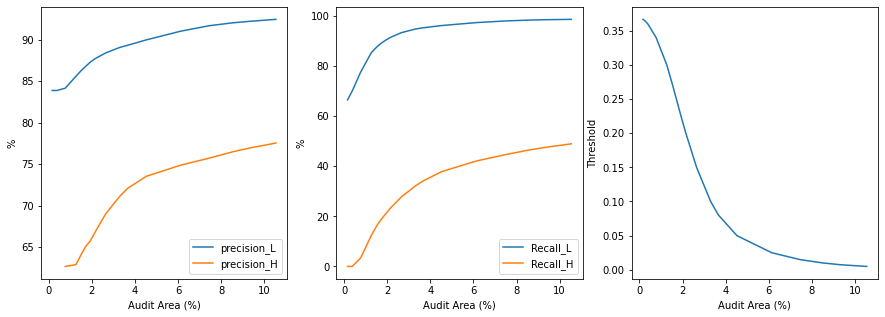

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [ ]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


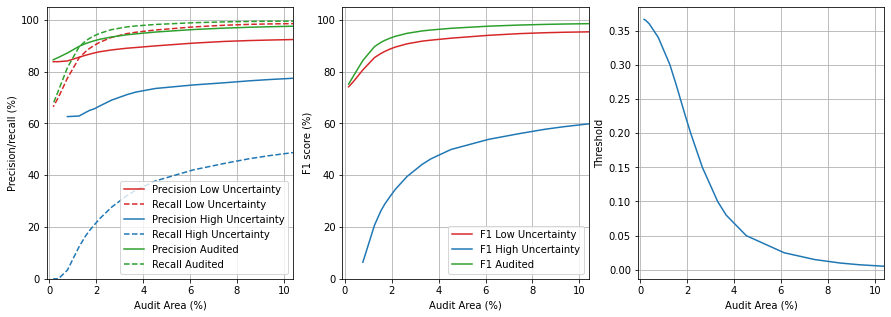

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [ ]:


m

{'precision_L': array([0.92460194, 0.92223801, 0.92038277, 0.91694121, 0.9104326 ,
        0.899806  , 0.89335459, 0.89078037, 0.8841371 , 0.87716217,
        0.87286479, 0.86772178, 0.86360086, 0.85590034, 0.84157306,
        0.8388178 , 0.8388178 , 0.8388178 ]),
 'recall_L': array([0.98595089, 0.98458102, 0.98286483, 0.9794588 , 0.97301315,
        0.96120461, 0.9522566 , 0.94722254, 0.93259608, 0.91380929,
        0.90259112, 0.88992187, 0.87749844, 0.8531737 , 0.77521167,
        0.70067111, 0.6757463 , 0.66472719]),
 'recall_Ltotal': array([0.29997568, 0.31953827, 0.33422709, 0.35758117, 0.38694601,
        0.43235544, 0.4663613 , 0.48320538, 0.51729387, 0.54700434,
        0.56124861, 0.5743652 , 0.58545339, 0.60432355, 0.63429936,
        0.64043231, 0.64043231, 0.64043231]),
 'AA': array([0.10543189, 0.09331771, 0.08529733, 0.07451545, 0.06140244,
        0.04524266, 0.03666858, 0.03301555, 0.02649088, 0.02150441,
        0.01925492, 0.01710638, 0.01539169, 0.01265056, 0.007686

In [ ]:
m_audited

{'precision': array([0.97602208, 0.97363533, 0.97174024, 0.96839608, 0.96294555,
        0.95329057, 0.94606895, 0.94260868, 0.93421066, 0.9252665 ,
        0.91994781, 0.91386428, 0.90851438, 0.89802579, 0.87235694,
        0.85513076, 0.84914355, 0.84618115]),
 'recall': array([0.99572556, 0.99499589, 0.99417312, 0.99250081, 0.98926792,
        0.98254961, 0.97661799, 0.9730767 , 0.96261229, 0.94840642,
        0.93942927, 0.92895438, 0.91826886, 0.89599939, 0.81607205,
        0.72640531, 0.69269155, 0.67698096]),
 'f1': array([0.98577537, 0.98419972, 0.98282869, 0.98030029, 0.97592928,
        0.96769897, 0.96110078, 0.9576004 , 0.94819884, 0.93669357,
        0.92958648, 0.92134755, 0.91336557, 0.89701144, 0.84327635,
        0.78552938, 0.76297985, 0.75218327])}

In [ ]:

importlib.reload(_metrics)


# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
#threshold_list2 = [0.09] # exp 77 PA 50 runs
# threshold_list2 = [0.085] # exp 77 PA 30 runs
# threshold_list2 = [0.085] # exp 77 PA 10 runs
# threshold_list2 = [0.083] # exp 77 PA 5 runs
threshold_list2 = [0.065] # exp 77 PA 5 runs
threshold_list2 = [0.06] # exp 77 PA 5 runs
threshold_list2 = [0.0825] # exp 77 PA 3 runs


ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (44634154,)
    label_mask_current_deforestation_test.shape: (44634154,)


threshold 0.0825
(43020268,) (43020268,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1613886,)
    predicted_test_classified_incorrect.shape: (1613886,)


cm_correct [[42548846    48276]
 [   20503   402643]]
cm_incorrect [[1120269   57470]
 [ 288471  147676]]


ic| TP_H + FN_H + FP_H + TN_H: 1613886
    len(label_mask_current_deforestation_test): 44634154
ic| TP_H + FN_H + FP_H + TN_H: 1613886
    len(label_mask_current_deforestation_test): 44634154


[0.89293864 0.95154627 0.46857475 0.0361581  0.71985805 0.33859226]
threshold 0.0825
(44634154,) (44634154,)
cm_audited [[43726585    48276]
 [   20503   838790]]
[0.94557789 0.97613969]


In [ ]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.0361581]),
         'f1_H': array([0.46055703]),
         'f1_L': array([0.92131134]),
         'precision_H': array([0.71985805]),
         'precision_L': array([0.89293864]),
         'recall_H': array([0.33859226]),
         'recall_L': array([0.95154627]),
         'recall_Ltotal': array([0.46857475])}
ic| m_audited2: {'f1': array([0.96061577]),
                 'precision': array([0.94557789]),
                 'recall': array([0.97613969])}


{'precision': array([0.94557789]),
 'recall': array([0.97613969]),
 'f1': array([0.96061577])}

In [ ]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (16795, 10420)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([171081287,   3922613], dtype=int64))


(array([0, 1], dtype=int8), array([171081287,   3922613], dtype=int64))

(-0.5, 10431.5, 16799.5, -0.5)

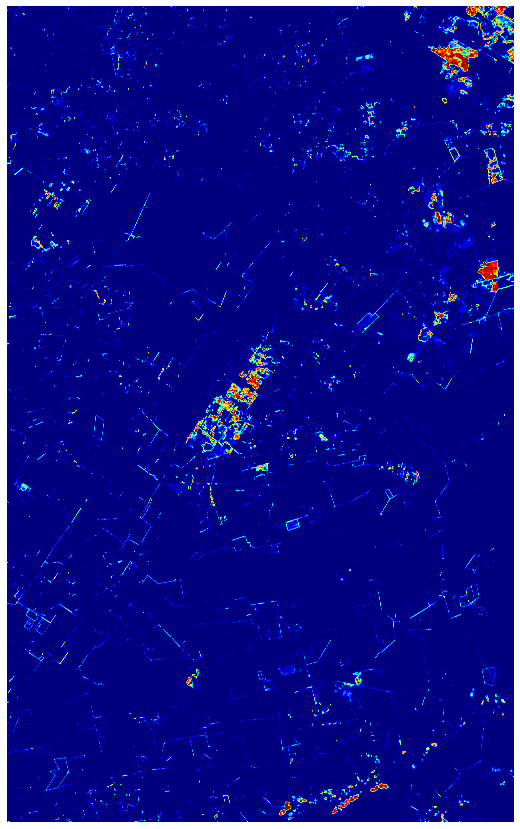

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy, cmap='jet')
plt.axis('off')


(-0.5, 10419.5, 16794.5, -0.5)

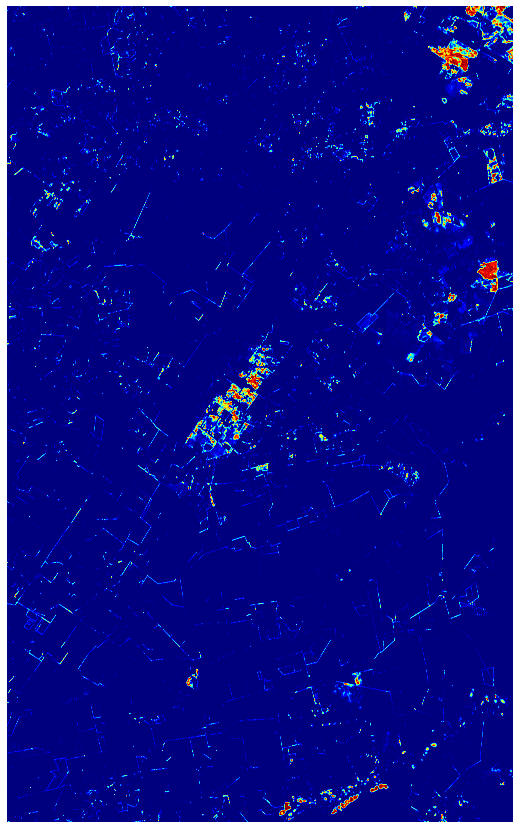

In [ ]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 10419.5, 16794.5, -0.5)

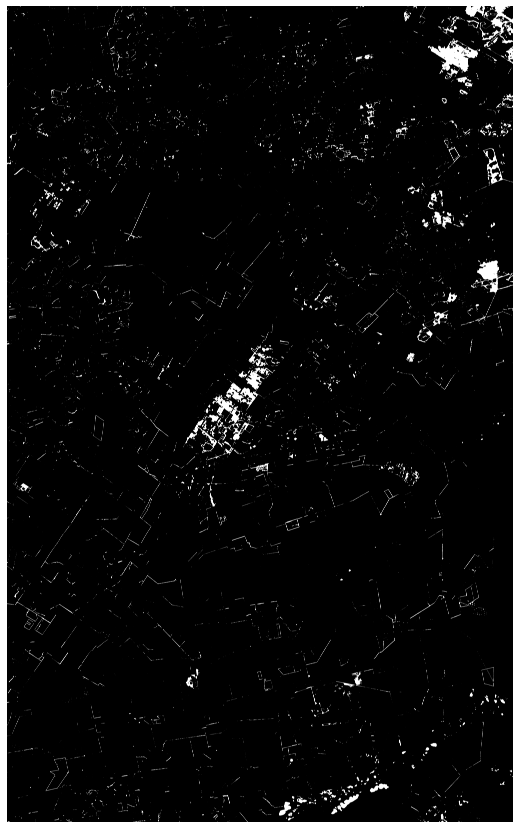

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [ ]:
np.unique(label_mask_val_valid, return_counts=True)

(array([0, 1], dtype=uint8), array([11564651,   243800], dtype=int64))

In [ ]:
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(uncertainty_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)



ic| uncertainty_val.shape: (11808451,)
    label_mask_val_valid.shape: (11808451,)


threshold 0.015
(11138810,) (11138810,)


ic| label_current_deforestation_test_classified_incorrect.shape: (669641,)
    predicted_test_classified_incorrect.shape: (669641,)
ic| TP_H + FN_H + FP_H + TN_H: 669641
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 669641
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[10975820     2039]
 [      80   160871]]
cm_incorrect [[578361   8431]
 [ 13209  69640]]
[0.98748389 0.99950295 0.65984824 0.05670862 0.89200856 0.84056537]
threshold 0.025
(11287985,) (11287985,)


ic| label_current_deforestation_test_classified_incorrect.shape: (520466,)
    predicted_test_classified_incorrect.shape: (520466,)
ic| TP_H + FN_H + FP_H + TN_H: 520466
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 520466
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11097525     2382]
 [     185   187893]]
cm_incorrect [[456656   8088]
 [ 13104  42618]]
[0.98748128 0.99901637 0.77068499 0.04407572 0.84049225 0.76483256]
threshold 0.05
(11449801,) (11449801,)


ic| label_current_deforestation_test_classified_incorrect.shape: (358650,)
    predicted_test_classified_incorrect.shape: (358650,)
ic| TP_H + FN_H + FP_H + TN_H: 358650
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 358650
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11236781     2746]
 [     452   209822]]
cm_incorrect [[317400   7724]
 [ 12837  20689]]
[0.98708178 0.99785042 0.86063167 0.03037232 0.72815261 0.61710314]
threshold 0.08
(11538994,) (11538994,)


ic| label_current_deforestation_test_classified_incorrect.shape: (269457,)
    predicted_test_classified_incorrect.shape: (269457,)
ic| TP_H + FN_H + FP_H + TN_H: 269457
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 269457
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11318143     3021]
 [     772   217058]]
cm_incorrect [[236038   7449]
 [ 12517  13453]]
[0.98627311 0.99645595 0.89031173 0.022819   0.64362262 0.51802079]
threshold 0.1
(11577880,) (11577880,)


ic| label_current_deforestation_test_classified_incorrect.shape: (230571,)
    predicted_test_classified_incorrect.shape: (230571,)
ic| TP_H + FN_H + FP_H + TN_H: 230571
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 230571
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11354129     3318]
 [     963   219470]]
cm_incorrect [[200052   7152]
 [ 12326  11041]]
[0.98510692 0.99563133 0.90020509 0.01952593 0.60688177 0.47250396]
threshold 0.15
(11644435,) (11644435,)


ic| label_current_deforestation_test_classified_incorrect.shape: (164016,)
    predicted_test_classified_incorrect.shape: (164016,)
ic| TP_H + FN_H + FP_H + TN_H: 164016
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 164016
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11415406     4133]
 [    1728   223168]]
cm_incorrect [[138775   6337]
 [ 11561   7343]]
[0.98181706 0.99231645 0.91537326 0.01388971 0.53676901 0.38843631]
threshold 0.2
(11688467,) (11688467,)


ic| label_current_deforestation_test_classified_incorrect.shape: (119984,)
    predicted_test_classified_incorrect.shape: (119984,)
ic| TP_H + FN_H + FP_H + TN_H: 119984
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 119984
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11455098     5213]
 [    2734   225422]]
cm_incorrect [[99083  5257]
 [10555  5089]]
[0.97739719 0.98801697 0.92461854 0.01016086 0.49188092 0.32530043]
threshold 0.25
(11728807,) (11728807,)


ic| label_current_deforestation_test_classified_incorrect.shape: (79644,)
    predicted_test_classified_incorrect.shape: (79644,)
ic| TP_H + FN_H + FP_H + TN_H: 79644
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 79644
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11490488     6766]
 [    4331   227222]]
cm_incorrect [[63693  3704]
 [ 8958  3289]]
[0.97108399 0.98129586 0.93200164 0.00674466 0.47032747 0.26855556]
threshold 0.27
(11739910,) (11739910,)


ic| label_current_deforestation_test_classified_incorrect.shape: (68541,)
    predicted_test_classified_incorrect.shape: (68541,)
ic| TP_H + FN_H + FP_H + TN_H: 68541
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 68541
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11499580     7470]
 [    4970   227890]]
cm_incorrect [[54601  3000]
 [ 8319  2621]]
[0.96826139 0.9786567  0.93474159 0.0058044  0.46628714 0.23957952]
threshold 0.3
(11755957,) (11755957,)


ic| label_current_deforestation_test_classified_incorrect.shape: (52494,)
    predicted_test_classified_incorrect.shape: (52494,)
ic| TP_H + FN_H + FP_H + TN_H: 52494
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 52494
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11512424     8600]
 [    6092   228841]]
cm_incorrect [[41757  1870]
 [ 7197  1670]]
[0.96378048 0.9740692  0.93864233 0.00444546 0.47175141 0.18833878]
threshold 0.34
(11778338,) (11778338,)


ic| label_current_deforestation_test_classified_incorrect.shape: (30113,)
    predicted_test_classified_incorrect.shape: (30113,)
ic| TP_H + FN_H + FP_H + TN_H: 30113
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 30113
    len(label_mask_current_deforestation_test): 11808451


cm_correct [[11529998    10193]
 [    7908   230239]]
cm_incorrect [[24183   277]
 [ 5381   272]]
[0.95760548 0.96679362 0.94437654 0.00255012 0.49544627 0.04811604]
threshold 0.36
(11792785,) (11792785,)


ic| label_current_deforestation_test_classified_incorrect.shape: (15666,)
    predicted_test_classified_incorrect.shape: (15666,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 15666
    len(label_mask_current_deforestation_test): 11808451
ic| TP_H + FN_H + FP_H + TN_H: 15666
    len(label_mask_current_deforestation_test): 11808451
ic| metrics_values_val: array([[0.98748389, 0.99950295, 0.65984824, 0.05670862, 0.89200856,
                                0.84056537],
                               [0.98748128, 0.99901637, 0.77068499, 0.04407572, 0.84049225,
                                0.76483256],
                               [0.98708178, 0.99785042, 0.86063167, 0.03037232, 0.72815261,
                                0.61710314],
                               [0.98627311, 0.99645595, 0.89031173, 0.022819  , 0.64362262,
                         

cm_correct [[11541611    10470]
 [   10193   230511]]
cm_incorrect [[12570     0]
 [ 3096     0]]
[0.95655259 0.95765338 0.94549221 0.00132668        nan 0.        ]


In [ ]:
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False

In [ ]:
threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


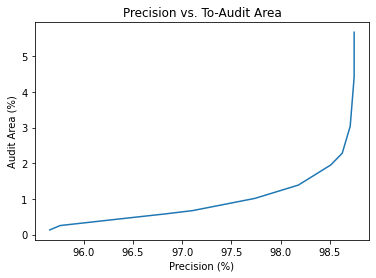

In [ ]:
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')

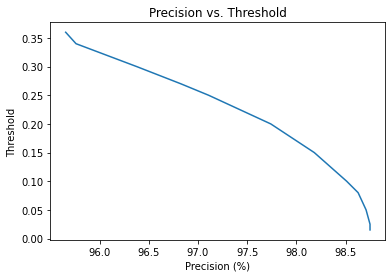

In [ ]:
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')

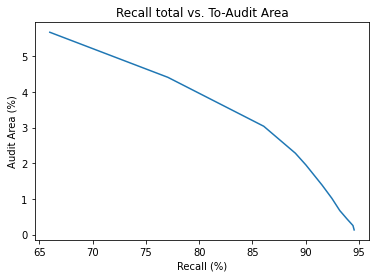

In [ ]:
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')

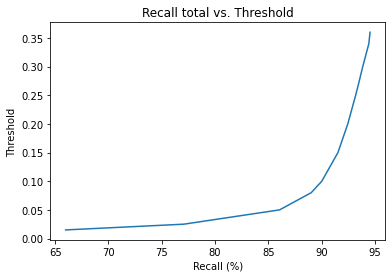

In [ ]:
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')

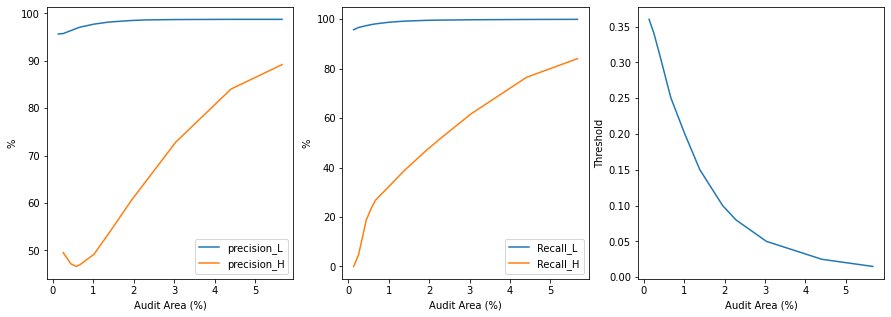

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')

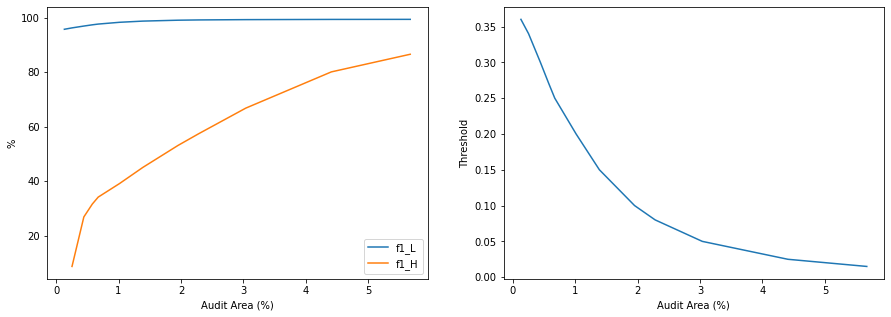

In [ ]:
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')

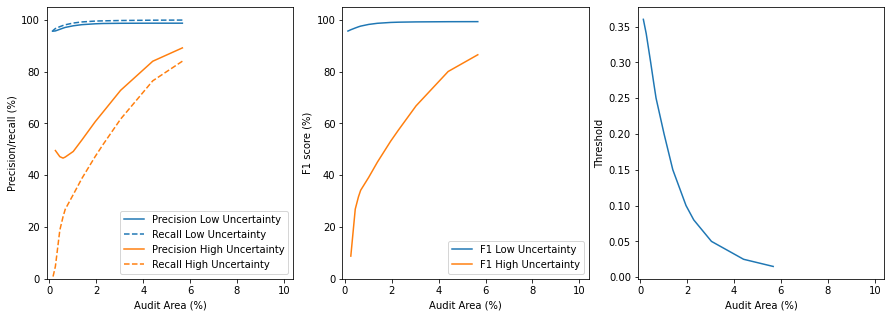

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')